In [12]:
# Torch-related imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset

# Scikit-learn-related imports
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score

# Nibabel and Scipy imports (for handling fMRI and image processing)
import nibabel as nib
import scipy.ndimage as ndimage  # For smoothing

# NumPy, Matplotlib, and Seaborn (for data manipulation and visualization)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# OS for file system operations
import os

In [13]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

# root_dir = os.path.join('/content/drive', 'My Drive', 'UCR', '2-2024', 'InvCC', 'ADHD200', 'Datasets', 'preprocessed')

root_dir = os.path.join('preprocessed')

# Carpetas para TDC y ADHD
tdc_dir = os.path.join(root_dir, 'TDC')
adhd_dir = os.path.join(root_dir, 'ADHD')

# Para guardar el estado del autoencoder
save_path = os.path.join(root_dir, 'autoencoder_0.pt')

# Listas para almacenar las rutas de archivos
tdc_file_paths = [os.path.join(tdc_dir, file) for file in os.listdir(tdc_dir) if file.endswith('.nii.gz')]
adhd_file_paths = [os.path.join(adhd_dir, file) for file in os.listdir(adhd_dir) if file.endswith('.nii.gz')]

# Etiquetas correspondientes
tdc_labels = [0] * len(tdc_file_paths)
adhd_labels = [1] * len(adhd_file_paths)

# Combinar rutas de archivos y etiquetas
file_paths = tdc_file_paths + adhd_file_paths
labels = tdc_labels + adhd_labels

In [15]:
import torch
import nibabel as nib
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from scipy import ndimage

class FMRI_Dataset(Dataset):
    def __init__(self, file_paths, labels, max_shape, smoothing_sigma=1, augment=False):
        self.file_paths = file_paths  # List of paths to the fMRI data files
        self.labels = labels  # Corresponding labels
        self.max_shape = max_shape  # Shape to pad all inputs to (e.g., [1, 53, 64, 46, 512])
        self.smoothing_sigma = smoothing_sigma  # Standard deviation for Gaussian smoothing
        self.augment = augment  # Apply augmentations if True

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load fMRI data using NiBabel
        fmri_img = nib.load(self.file_paths[idx])
        data = fmri_img.get_fdata()  # Extract the fMRI data as a NumPy array

        # Apply Gaussian smoothing
        data = self.smooth_data(data)

        # Apply augmentations if enabled
        if self.augment:
            data = self.apply_augmentations(data)

        # Normalize the data
        data = self.normalize_data(data)

        # Convert to tensor and add missing dimensions
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

        # Pad the tensor to the specified max_shape
        data_padded = F.pad(data_tensor, pad=self.calculate_padding(data_tensor.shape), mode='constant', value=0)

        # Ensure that the final shape matches max_shape exactly
        data_padded = data_padded.view(*self.max_shape)

        # Get the label
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        print(f"Label at index {idx}: {label}")

        return data_padded, label

    def apply_augmentations(self, data):
        # Add Gaussian noise
        data = self.add_noise(data, mean=0, std=0.01)

        # Apply random rotation
        data = self.random_rotate(data)

        # Apply random intensity shift
        data = self.random_intensity_shift(data, shift_limit=0.05)

        return data

    def add_noise(self, data, mean=0, std=0.01):
        noise = np.random.normal(mean, std, data.shape)
        return data + noise

    def random_rotate(self, data):
        angles = np.random.uniform(-5, 5, size=3)  # Small random rotation angles for x, y, z axes
        return ndimage.rotate(data, angle=angles[0], axes=(1, 2), reshape=False, mode='nearest')

    def random_intensity_shift(self, data, shift_limit=0.05):
        shift_value = np.random.uniform(-shift_limit, shift_limit)
        return data + shift_value

    def calculate_padding(self, current_shape):
        padding = []
        for current_dim, max_dim in zip(reversed(current_shape), reversed(self.max_shape)):
            pad_total = max_dim - current_dim
            padding.append(pad_total // 2)  # pad_left or pad_top
            padding.append(pad_total - (pad_total // 2))  # pad_right or pad_bottom
        return padding

    def normalize_data(self, data):
        """Normalize the data to zero mean and unit variance."""
        mean = data.mean()
        std = data.std()
        if std > 0:  # Avoid division by zero
            data = (data - mean) / std
        return data

    def smooth_data(self, data):
        """Apply Gaussian smoothing to the data."""
        return ndimage.gaussian_filter(data, sigma=self.smoothing_sigma)

In [ ]:
# Determine the maximum shape across all tensors
max_shape = [1, 49, 58, 47, 512]

# Create the dataset with padded tensors
from collections import Counter

# Assuming you have an instance of your FMRI_Dataset
dataset = FMRI_Dataset(file_paths, labels, max_shape)

# Count the labels
label_counts = Counter(dataset.labels)
print("Class distribution:", label_counts)

sample_data, sample_label = dataset[0]
print(sample_data.shape, sample_label)

Class distribution: Counter({1: 1462, 0: 1340})
Label at index 0: 0
torch.Size([1, 53, 64, 46, 512]) tensor(0)


In [17]:
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import torch

# Assuming `dataset` is your instantiated FMRI_Dataset class with labels.

# Create a StratifiedShuffleSplit object to split into training and test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Ensure labels are on CPU for compatibility with sklearn
labels_cpu = dataset.labels.cpu().numpy() if isinstance(dataset.labels, torch.Tensor) else dataset.labels

# Split into training/validation and test sets
for train_val_idx, test_idx in sss.split(range(len(dataset)), labels_cpu):
    train_val_set = Subset(dataset, train_val_idx)
    testset = Subset(dataset, test_idx)

# Create another StratifiedShuffleSplit for training and validation sets
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)  # 0.25 of 0.8 gives 0.2 total for validation

# Access labels for train_val_set
train_val_labels = [labels_cpu[i] for i in train_val_idx]  # Use list comprehension to retrieve labels

# Split train_val_set into train and validation sets
for train_idx, val_idx in sss_val.split(range(len(train_val_set)), train_val_labels):
    trainset = Subset(train_val_set, train_idx)
    valset = Subset(train_val_set, val_idx)

# Create dataloaders
batch_size = 4
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

class_names = ["TDC", "ADHD"]

# Verify the dataloaders
# Print shapes of a sample batch from the training loader
for images, labels in trainloader:
    if images is not None:
        print(f"Train - Shape of inputs: {images.shape}, Shape of labels: {labels.shape}")
        break

# Print shapes of a sample batch from the test loader
for images, labels in testloader:
    if images is not None:
        print(f"Test - Shape of inputs: {images.shape}, Shape of labels: {labels.shape}")
        break

Label at index 1934: 1
Label at index 2741: 1
Label at index 2355: 1
Label at index 909: 0
Train - Shape of inputs: torch.Size([4, 1, 53, 64, 46, 512]), Shape of labels: torch.Size([4])
Label at index 972: 0
Label at index 612: 0
Label at index 1147: 0
Label at index 1262: 0
Test - Shape of inputs: torch.Size([4, 1, 53, 64, 46, 512]), Shape of labels: torch.Size([4])


In [18]:
print(f"Number of samples in valloader: {len(valloader.dataset)}")
print(f"Number of samples in trainloader: {len(trainloader.dataset)}")
print(f"Number of samples in testloader: {len(testloader.dataset)}")

Number of samples in valloader: 561
Number of samples in trainloader: 1680
Number of samples in testloader: 561


In [23]:
import nibabel as nib

# Loop through each file path
for i, file_path in enumerate(file_paths):
    # Load the fMRI data
    img = nib.load(file_path)
    data = img.get_fdata()
    
    # Print the data shape and voxel dimensions
    print(f"File {i+1}:")
    print(f"  Data shape: {data.shape}")
    print(f"  Voxel dimensions: {img.header.get_zooms()}")
    print("-" * 30)


File 1:
  Data shape: (49, 58, 47, 10)
  Voxel dimensions: (4.0, 4.0, 4.0, 1.0)
------------------------------
File 2:
  Data shape: (53, 64, 46, 171)
  Voxel dimensions: (3.0, 3.0, 3.0, 2.0)
------------------------------
File 3:
  Data shape: (197, 233, 189)
  Voxel dimensions: (1.0, 1.0, 1.0)
------------------------------
File 4:
  Data shape: (197, 233, 189)
  Voxel dimensions: (1.0, 1.0, 1.0)
------------------------------
File 5:
  Data shape: (197, 233, 189)
  Voxel dimensions: (1.0, 1.0, 1.0)
------------------------------
File 6:
  Data shape: (49, 58, 47)
  Voxel dimensions: (4.0, 4.0, 4.0)
------------------------------
File 7:
  Data shape: (197, 233, 189)
  Voxel dimensions: (1.0, 1.0, 1.0)
------------------------------
File 8:
  Data shape: (49, 58, 47, 257)
  Voxel dimensions: (4.0, 4.0, 4.0, 1.96)
------------------------------
File 9:
  Data shape: (197, 233, 189)
  Voxel dimensions: (1.0, 1.0, 1.0)
------------------------------
File 10:
  Data shape: (49, 58, 47)
 

KeyboardInterrupt: 

Class distribution: Counter({tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1})


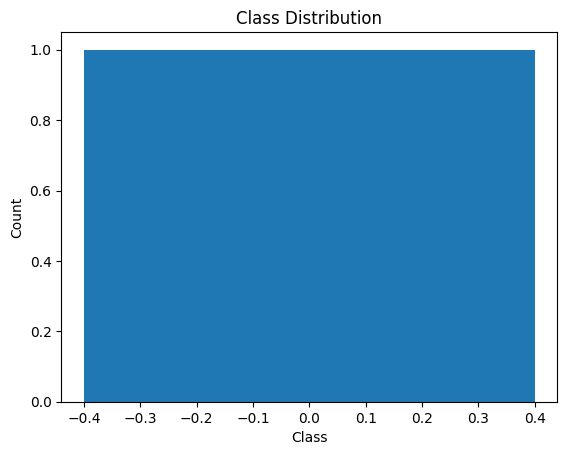

In [20]:
from collections import Counter
import matplotlib.pyplot as plt

# Count occurrences of each class label
class_counts = Counter(labels)
print("Class distribution:", class_counts)

# Visualize the distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


In [21]:
print(dataset.labels)  # Inspect the label values to confirm they are correct


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [22]:
import numpy as np

intensities = [np.mean(nib.load(fp).get_fdata()) for fp in file_paths]
plt.hist(intensities, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.title("Voxel Intensity Distribution")
plt.show()


KeyboardInterrupt: 

In [ ]:
# Assuming fMRI data is 4D [X, Y, Z, T] with T as the time dimension
time_series = sample_data.mean(axis=(0, 1, 2))  # Averaging across spatial dimensions

plt.plot(time_series)
plt.xlabel("Time (Volume Index)")
plt.ylabel("Mean Signal Intensity")
plt.title("Mean Signal Intensity Over Time")
plt.show()


In [ ]:
# Visualizing intensity distribution across a random slice
slice_idx = sample_data.shape[2] // 2  # Middle slice
plt.imshow(sample_data[:, :, slice_idx], cmap="gray")
plt.colorbar()
plt.title("Intensity Distribution on Middle Slice")
plt.show()


In [ ]:
mean_intensity = []
std_intensity = []
for fp in file_paths:
    data = nib.load(fp).get_fdata()
    mean_intensity.append(data.mean())
    std_intensity.append(data.std())

plt.subplot(1, 2, 1)
plt.hist(mean_intensity, bins=30, color="lightblue")
plt.xlabel("Mean Intensity")
plt.title("Mean Intensity Distribution")

plt.subplot(1, 2, 2)
plt.hist(std_intensity, bins=30, color="salmon")
plt.xlabel("Standard Deviation")
plt.title("Standard Deviation Distribution")
plt.show()


In [ ]:
# Calculate correlation between adjacent time points
corr_values = [np.corrcoef(sample_data[:, :, :, t].ravel(), sample_data[:, :, :, t+1].ravel())[0, 1] for t in range(sample_data.shape[3] - 1)]
plt.plot(corr_values)
plt.xlabel("Time Point")
plt.ylabel("Correlation with Next Frame")
plt.title("Temporal Correlation between Adjacent Frames")
plt.show()
